# Importing Libraries#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras as k
import pandas as pd
from PIL import Image
import time
import wv
from skimage.measure import compare_ssim as ssim

Using TensorFlow backend.


# Dataset #

In [4]:
def open_kmnist():
    import idx2numpy
    np.random.seed(1234)
    file = ['t10k-images-idx3-ubyte','t10k-labels-idx1-ubyte','train-images-idx3-ubyte','train-labels-idx1-ubyte']
    x_test = np.array(idx2numpy.convert_from_file(file[0]))
    y_test = np.array(idx2numpy.convert_from_file(file[1]))
    x_train = np.array(idx2numpy.convert_from_file(file[2]))
    y_train = np.array(idx2numpy.convert_from_file(file[3]))
    
    aux = np.zeros((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    aux2 = np.zeros((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

    for z in range (x_train.shape[0]):
        aux[z,:] = np.ndarray.flatten(x_train[z,:,:])

    for z in range(x_test.shape[0]):
        aux2[z,:] = np.ndarray.flatten(x_test[z,:,:])

    x_train = aux/255
    x_test = aux2/255
    np.random.shuffle(aux)
    np.random.shuffle(aux2)    
    return x_train, y_train, x_test, x_test[:4000,:]

def banco(opc):
    #limiar = 4000 # amostras para teste
    np.random.seed(1234)
    if(opc =='mnist'):
        (x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()
    else:
        if(opc =='fash'):
            (x_train, y_train), (x_test, y_test) = k.datasets.fashion_mnist.load_data()
    aux = np.zeros((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    aux2 = np.zeros((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

    for z in range (x_train.shape[0]):
        aux[z,:] = np.ndarray.flatten(x_train[z,:,:])
    
    for z in range(x_test.shape[0]):
        aux2[z,:] = np.ndarray.flatten(x_test[z,:,:])
    aux = aux/255
    aux2 = aux2/255
    np.random.shuffle(aux)
    np.random.shuffle(aux2)
    x_train = aux
    x_test = aux2
    x_test2 = aux2[:4000,:]
    return x_train, x_test, x_test2

In [3]:
def sigmoid(x):
    sig = (1/(1+np.exp(-x))).astype(float)
    return sig

def pseudo_likelihood(visibles, weights, a, b):
    x = visibles
    x[x>.5] = 1
    x[x<.5] = 0
    x = x.reshape((visibles.shape[0], visibles.shape[1]))
    free0 = free_energy(x, weights, a, b)
    idx_rot = np.random.randint(0, visibles.shape[1], visibles.shape[0])
    x_bit=x
    x_rot=x
    for z in range(visibles.shape[0]):
        x_bit[z,idx_rot[z]] = 1 - x_rot[z,idx_rot[z]]
    free1 = free_energy(x_bit, weights, a, b)
    cost = np.mean(neurons_visible*np.log(sigmoid(free1 - free0)))
    return cost

def free_energy (visibles, weights, a, b):
    f1 = np.zeros((visibles.shape[0]))
    for z in range(visibles.shape[0]):
        wx_b = np.matmul(visibles[z,:], weights) + b[z,:]
        vbias_term = -np.matmul(a[z,:].T, visibles[z,:])
        hidden_term = -np.sum(np.log(1 + np.exp(wx_b)))
        f1[z] = hidden_term + vbias_term
    res = np.mean(f1)
    return res

def energy (visibles, hidden, weights, a, b):
    e = np.zeros((visibles.shape[0]))
    for z in range(visibles.shape[0]):
        dif = -np.matmul(a[z,:].T,visibles[z,:])
        dif2 = -np.matmul(b[z,:].T,hidden[z,:])
        aux = np.matmul(weights, hidden[z,:].T)
        dif3 = -np.matmul(aux, visibles[z,:])
        e[z] = dif + dif2 + dif3
    e = np.mean(e)
    return  np.array(e)

In [4]:
def make_ssim(weights, a, b, dados):
    ssim_rec = 0
    for z in range(dados.shape[0]):
        img = dados[z,:].reshape((28,28))
        new,_ = rec(dados[z,:], weights, a, b, 1)
        new = new.reshape((28,28))
        rows, cols = img.shape
        ssim_rec += ssim(img, new, data_range=img.max() - img.min())
    media = ssim_rec/dados.shape[0]
    return np.round(media,4)

def rec (data, weights, a, b, kstp):
    visibles = data
    for i in range(kstp):
        var1 = np.dot(visibles, weights)
        var1 = var1 + np.mean(b, axis = 0)

        pos_hidden_prob = (sigmoid(var1))
        pos_hidden_state = pos_hidden_prob > np.random.uniform(size = pos_hidden_prob.shape)
        H_0 = pos_hidden_state.astype(int)
        
        var1 = sigmoid((np.dot(weights, H_0.T) + np.mean(a, axis = 0)))
        V_normal = var1

    return (V_normal, H_0)

def save_data (op, drop_name, weights, a, b, error, learning_rate, neurons_hidden, epochs, k, energ, fe, cost, cost2, i, train_ssim, test_ssim):
    w = pd.DataFrame(weights)
    w.to_csv(str(op)+'_'+str(drop_name)+'_weights'+str(i)+'.csv')
    
    a1 = pd.DataFrame(a)
    a1.to_csv(str(op)+'_'+str(drop_name)+'_a'+str(i)+'.csv')
    
    b1 = pd.DataFrame(b)
    b1.to_csv(str(op)+'_'+str(drop_name)+'_b'+str(i)+'.csv')
    
    error = pd.DataFrame(error)
    error.to_csv(str(op)+'_'+str(drop_name)+'_error'+str(i)+'.csv')
    
    e = pd.DataFrame(energ)
    e.to_csv(str(op)+'_'+str(drop_name)+'_energ'+str(i)+'.csv')
    
    f = pd.DataFrame(fe)
    f.to_csv(str(op)+'_'+str(drop_name)+'_free'+str(i)+'.csv')
    
    cost = pd.DataFrame(cost)
    cost.to_csv(str(op)+'_'+str(drop_name)+'_cost'+str(i)+'.csv')
    
    cost2 = pd.DataFrame(cost2)
    cost2.to_csv(str(op)+'_'+str(drop_name)+'_cost2'+str(i)+'.csv')
    
    train_ssim = pd.DataFrame(train_ssim)
    train_ssim.to_csv(str(op)+'_'+str(drop_name)+'_trssim'+str(i)+'.csv')
    
    test_ssim = pd.DataFrame(test_ssim)
    test_ssim.to_csv(str(op)+'_'+str(drop_name)+'_tsssim'+str(i)+'.csv')
    
    save = {'Learning Rate': [learning_rate], 'Hidden Units':[neurons_hidden], 'Epochs':[epochs], 'K-Steps':[k]}
    save = pd.DataFrame(save)
    save.to_csv(str(op)+'_'+str(drop_name)+'_parameters'+str(i)+'.csv')

In [5]:
def runGibbsStep(data, weights, a, b, kstp):
    V_0 = data
    i=0
    for i in range(kstp):                
        var1 = np.matmul(V_0, weights) + b
        pos_hidden_prob = sigmoid(var1)
        pos_hidden_state = pos_hidden_prob > np.random.uniform(size = pos_hidden_prob.shape)
        H_New = pos_hidden_state.astype(int)        
        
        x_1 = np.matmul(H_New, weights.T) + a 
        visible_prob = sigmoid(x_1)
        visible_prob_state = visible_prob > np.random.uniform(size=visible_prob.shape)
        V_0 = visible_prob_state.astype(int)
        
    return (V_0, H_New, pos_hidden_prob, visible_prob)

def gera_sample(x_test2, weights, a, b):
    n_samples = 20
    n_samples2 = 60
    n_chains = 20
    image_data = np.zeros((29 * n_samples + 1, 29 * n_chains - 1), dtype='uint8')
    vis_mf = np.zeros((n_samples2, 784, n_samples))
    vis_mf2 = np.zeros((n_samples2, 784, n_samples))
    idx2 = 0
    for z in range(n_samples):
        k = 0
        for idx in range(idx2, idx2 + n_samples2):
            data = np.array(x_test2[idx,:])
            vis_mf[k,:,z], _ = rec(data, weights, a, b, 1)
            vis_mf2[k,:,z] = data
            k+=1
        idx2 +=n_samples2


    for idx in range(n_samples):
        image_data[29 * idx:29 * idx + 28, :] = wv.tile_raster_images(X=vis_mf[:,:,idx], img_shape=(28, 28),
                                                                      tile_shape=(1, n_chains), tile_spacing=(1, 1))
    image = Image.fromarray(image_data)
    #image.show()
    #image.save(str(name)+'_samples'+'.png')
    
    for idx in range(n_samples):
        image_data[29 * idx:29 * idx + 28, :] = wv.tile_raster_images(X=vis_mf2[:,:,idx], img_shape=(28, 28),
                                                                      tile_shape=(1, n_chains), tile_spacing=(1, 1))
    image = Image.fromarray(image_data)
    #image.show()
    #image.save(str(name)+'_original_samples.png')

In [6]:
def train_rbm(x_train, x_test, weights, k, a, b, learning_rate, dropout, drop_std):
    neurons_history = np.ones((epochs*const, neurons_hidden))
    c = 0
    cont = 0
    data = np.zeros((batch,neurons_visible))
    mi = np.zeros((neurons_visible))
    aux1 = np.zeros((batch, neurons_visible))
    epoch = 0
    q = batch
    t1 = 1
    energ = []
    error2 =[]
    gi = np.zeros((const, neurons_hidden)) # "grau de importância" para a decisão do Dropout
    par = 0
    cost =[]
    cost2=[]
    test_ssim = np.zeros((epochs))
    train_ssim = np.zeros((epochs))
    error = []
    g1 = np.ones((1,neurons_hidden))
    for epoch in range(epochs):
        q = 0
        aux = 0
        for aux in range(batch):
            data[aux,:] = x_train[aux,:]
            q += 1
        tr_ssim = 0
        for i in range(0,const):            
            var1 = np.matmul(data, weights) + b
            pos_hidden_prob = np.array(sigmoid(var1))
            thre = np.random.uniform(size = pos_hidden_prob.shape)
            pos_hidden_state = pos_hidden_prob > thre
            H_0 = pos_hidden_state.astype(int)
            e1 = energy(data, H_0, weights, a, b)
          
            mi = np.matmul(H_0, weights.T) + a
            visible_prob = sigmoid(mi)
            thre2 = np.random.uniform(size=visible_prob.shape)
            visible_prob_state = visible_prob > thre2
            V_0 = visible_prob_state.astype(int)

            V_new, H_new, P_new, visible_prob = runGibbsStep(V_0, weights, a, b, 1)
            e2 = energy(V_new, H_new, weights, a, b)
            et = e2-e1
            energ.append(et)
            
            if(dropout):                
                gi[i,:] = np.mean((P_new/np.abs(e2))/np.max(P_new/np.abs(e2)), axis = 0)
                
            pos_grad = np.matmul(data.T, pos_hidden_prob)
            neg_grad = np.matmul(V_new.T, P_new)
            res = (data - V_new)
            b1 = (pos_hidden_prob - P_new)
            
            weights = weights + learning_rate*((pos_grad - neg_grad)/batch)            
            a = a + learning_rate*res
            b = b + learning_rate*b1
             
            err = np.sum((data - V_new)**2)/batch
            
            error2.append(err)
            error.append(err)
            
            cost.append(pseudo_likelihood(V_new, weights, a, b))
            tr_ssim+=make_ssim(weights,a,b,data)
            if(dropout):
                if i+1==const:
                    test_ssim[epoch] = make_ssim(weights, a, b, x_test)
                if(par == 0 and (i+2)<const):
                    g1 = gi[i,:]#.copy()
                    indices = []
                    w8 = weights.copy()
                    rand = np.random.uniform(0,1,size=g1.shape)
                    drop = g1 < rand
                    drop = drop.astype(int)
                    for z in range(neurons_hidden):
                        weights[:,z] = weights[:,z]*drop[z]
                        neurons_history[c,z] = neurons_history[c,z]*drop[z]
                        if(drop[z]==0):
                            indices.append(z)
                    indices=np.array(indices)
                    #print("Neurons Off: ", len(indices))
                    par = 1
                else:
                    if(len(indices)!=0):                    
                        weights[:,indices] = w8[:,indices]
                        #print("Neurons Agreg!")
                    par = 0
            else:
                drop = 0
                if(drop_std):
                    if i+1==const:
                        w = weights*.5 # 1/p -> for pre-trained nets
                        test_ssim[epoch] = make_ssim(w, a, b, x_test)
                    if(par == 0 and (i+2)<const):
                        g1 = np.random.binomial(1,.5,size=(1,neurons_hidden))
                        indices = []
                        w8 = weights.copy()
                        #drop = g1#np.random.binomial(1,.5,size=(1,neurons_hidden))
                        for z in range(neurons_hidden):
                            weights[:,z] = weights[:,z]*g1[0,z]
                            neurons_history[c,z] = neurons_history[c,z]*g1[0,z]
                            if(g1[0,z]==0):
                                indices.append(z)
                        indices=np.array(indices)
                        #print("Neurons Off: ", len(indices))
                        par = 1
                    else:
                        if(len(indices)!=0):
                            weights[:,indices] = w8[:,indices]
                            #print("Neurons Agregated!")
                        par = 0
                else:
                    if i+1==const:
                        test_ssim[epoch] = make_ssim(weights, a, b, x_test)
            cont += 1
            z=0
            c += 1
            for aux in range(q,q+batch):
                if (aux == x_train.shape[0]):
                    break
                data[z,:] = x_train[aux,:]
                q += 1
                z += 1
        cost2.append(np.mean(cost[(cont-const):(cont-1)]))
        train_ssim[epoch] = tr_ssim/const
        print("Epoch: %s, LR: %s, error: %s, NLL: %s, ssim %s" % (epoch, learning_rate, np.round(np.mean(error2),3),cost2[epoch], test_ssim[epoch]))
        error2 = []
    return weights, a, b, error, energ, drop, fe, cost, cost2, train_ssim, test_ssim, neurons_history

In [7]:
#states = [(False,False),(True,False),(False,True)]

states = [(False,True), (True, False), (False,False)]

In [8]:
start = time.time()
k = 1
#bol = True # energy-based dropout
#drop_std = True  #standard-based dropout
op = ['kmnist','fash', 'mnist']
for oc in range(3): #3
    import keras as k
    if op[oc] == 'kmnist':
        name2 = 'kmnist_'
        x_train, y_train, x_test, x_test2 = open_kmnist()
    else:
        if op[oc] == 'fash':
            name2 = 'fash_'
            x_train, x_test, x_test2 = banco(op[oc])
        else:
            if op[oc] == 'mnist':
                name2 = 'mnist_'
                x_train, x_test, x_test2 = banco(op[oc])
    for r in range(3): # to change between drop methods
        for z in range(10): #seeds
            bol, drop_std = states[r]
            
            if drop_std:
                name = str(name2)+'dropstd'
                drop_name = 'dropstd'
            else:
                if bol:
                    name = str(name2)+'drop'
                    drop_name='drop'
                else:
                    name = str(name2)+'naive'
                    drop_name='naive'
            print(name)
            print(op[oc])
            np.random.seed(z)
            neurons_hidden = 2**8 #256
            neurons_visible = x_train.shape[1]
            epochs = 30
            batch = 2**7
            const = int(x_train.shape[0]//batch)
            learning_rate = 0.1

            weights = np.array(np.random.normal(loc = 0, scale = 0.01,size = (neurons_visible, neurons_hidden)))
            a = np.zeros(shape=(batch, neurons_visible))
            b = np.zeros(shape=(batch, neurons_hidden))

            weights, a, b, error, energ, drop, fe, cost,cost2, train_ssim, test_ssim, neurons_history = train_rbm(x_train, x_test, weights, 1, a, b, learning_rate, bol, drop_std)
            print(test_ssim)
            gera_sample(x_test2, .5*weights, a, b) # PRECISO GERAR NOVAMENTE OS MOSAICOS!
            save_data(op[oc], drop_name, weights, a, b, error, learning_rate, neurons_hidden, epochs, k, energ, fe, cost, cost2, z, train_ssim, test_ssim)

            image = Image.fromarray(wv.tile_raster_images(X = weights.T,img_shape=(28, 28),tile_shape=(16, 16),tile_spacing=(1, 1)))
            image.show()
            image.save('w8_'+str(name)+str(z)+'.png')
            print("exec",z,"terminada")
        neurons_history = pd.DataFrame(neurons_history) # utilizo para gerar histogramas de desligamento de cada neuron.
        neurons_history.to_csv('activation_hidden_'+str(name)+'.csv')
end = time.time()

kmnist_dropstd
kmnist
Epoch: 0, LR: 0.1, error: 171.749, NLL: -152.820892912992, ssim 0.2585
Epoch: 1, LR: 0.1, error: 135.101, NLL: -77.62873488303596, ssim 0.3594
Epoch: 2, LR: 0.1, error: 125.368, NLL: -62.90616392150637, ssim 0.4163
Epoch: 3, LR: 0.1, error: 120.308, NLL: -56.14284198812999, ssim 0.4493
Epoch: 4, LR: 0.1, error: 117.047, NLL: -49.340977231375284, ssim 0.4729
Epoch: 5, LR: 0.1, error: 114.752, NLL: -45.96168822592741, ssim 0.4904
Epoch: 6, LR: 0.1, error: 112.764, NLL: -42.38455855549236, ssim 0.5008
Epoch: 7, LR: 0.1, error: 111.515, NLL: -39.88595044681923, ssim 0.5104
Epoch: 8, LR: 0.1, error: 110.404, NLL: -38.123515843369276, ssim 0.5143
Epoch: 9, LR: 0.1, error: 109.482, NLL: -36.033721018074765, ssim 0.5192
Epoch: 10, LR: 0.1, error: 108.462, NLL: -34.409904197027544, ssim 0.5223
Epoch: 11, LR: 0.1, error: 108.149, NLL: -32.67155000985337, ssim 0.5282
Epoch: 12, LR: 0.1, error: 107.277, NLL: -31.088270700169566, ssim 0.5285
Epoch: 13, LR: 0.1, error: 107.139,

Epoch: 12, LR: 0.1, error: 108.021, NLL: -31.040731513451952, ssim 0.5282
Epoch: 13, LR: 0.1, error: 107.297, NLL: -29.313920170052747, ssim 0.5322
Epoch: 14, LR: 0.1, error: 106.561, NLL: -28.702788329582877, ssim 0.5312
Epoch: 15, LR: 0.1, error: 106.303, NLL: -28.438761276388902, ssim 0.5352
Epoch: 16, LR: 0.1, error: 106.245, NLL: -27.190445712607676, ssim 0.5366
Epoch: 17, LR: 0.1, error: 105.771, NLL: -26.477353625917004, ssim 0.5355
Epoch: 18, LR: 0.1, error: 105.514, NLL: -26.0915448422082, ssim 0.5392
Epoch: 19, LR: 0.1, error: 105.157, NLL: -25.141375096189336, ssim 0.5393
Epoch: 20, LR: 0.1, error: 105.012, NLL: -24.3107117396574, ssim 0.5411
Epoch: 21, LR: 0.1, error: 104.855, NLL: -24.70926880359822, ssim 0.5389
Epoch: 22, LR: 0.1, error: 104.826, NLL: -24.026240091318112, ssim 0.5364
Epoch: 23, LR: 0.1, error: 104.289, NLL: -22.660348745869747, ssim 0.5358
Epoch: 24, LR: 0.1, error: 104.052, NLL: -22.99767429651039, ssim 0.537
Epoch: 25, LR: 0.1, error: 104.331, NLL: -21.

Epoch: 25, LR: 0.1, error: 104.048, NLL: -21.814071315395804, ssim 0.5256
Epoch: 26, LR: 0.1, error: 103.715, NLL: -20.993267356614858, ssim 0.5292
Epoch: 27, LR: 0.1, error: 103.881, NLL: -21.5721302308115, ssim 0.5251
Epoch: 28, LR: 0.1, error: 103.528, NLL: -20.665562322427416, ssim 0.522
Epoch: 29, LR: 0.1, error: 103.624, NLL: -20.736556598130097, ssim 0.5251
[0.2602 0.3602 0.4169 0.4493 0.4759 0.4931 0.5019 0.5114 0.5188 0.5236
 0.526  0.5259 0.528  0.5298 0.531  0.5327 0.5307 0.5329 0.5292 0.5281
 0.5283 0.5303 0.5304 0.5285 0.5286 0.5256 0.5292 0.5251 0.522  0.5251]
exec 6 terminada
kmnist_dropstd
kmnist
Epoch: 0, LR: 0.1, error: 171.993, NLL: -154.597497152176, ssim 0.2607
Epoch: 1, LR: 0.1, error: 134.865, NLL: -76.55086009818814, ssim 0.3611
Epoch: 2, LR: 0.1, error: 125.404, NLL: -62.14640942612433, ssim 0.4156
Epoch: 3, LR: 0.1, error: 120.229, NLL: -55.21728197440067, ssim 0.4502
Epoch: 4, LR: 0.1, error: 116.995, NLL: -50.64709888741751, ssim 0.4717
Epoch: 5, LR: 0.1, er

Epoch: 4, LR: 0.1, error: 122.926, NLL: -52.944616710157575, ssim 0.4829
Epoch: 5, LR: 0.1, error: 119.619, NLL: -47.21877375812452, ssim 0.4857
Epoch: 6, LR: 0.1, error: 116.685, NLL: -41.184789129102306, ssim 0.4898
Epoch: 7, LR: 0.1, error: 115.043, NLL: -39.47877544204132, ssim 0.495
Epoch: 8, LR: 0.1, error: 113.751, NLL: -36.38524461082425, ssim 0.4956
Epoch: 9, LR: 0.1, error: 112.596, NLL: -35.642363129187984, ssim 0.5008
Epoch: 10, LR: 0.1, error: 111.843, NLL: -35.6479947326451, ssim 0.5039
Epoch: 11, LR: 0.1, error: 111.086, NLL: -33.77482842020363, ssim 0.5089
Epoch: 12, LR: 0.1, error: 110.546, NLL: -32.28486456058734, ssim 0.515
Epoch: 13, LR: 0.1, error: 110.149, NLL: -31.98153089328626, ssim 0.5154
Epoch: 14, LR: 0.1, error: 109.377, NLL: -29.283400189510964, ssim 0.5188
Epoch: 15, LR: 0.1, error: 109.144, NLL: -28.26733238496332, ssim 0.5194
Epoch: 16, LR: 0.1, error: 108.779, NLL: -28.998086063978768, ssim 0.5248
Epoch: 17, LR: 0.1, error: 108.506, NLL: -27.8458099277

Epoch: 17, LR: 0.1, error: 107.96, NLL: -27.26840205310453, ssim 0.5249
Epoch: 18, LR: 0.1, error: 107.695, NLL: -26.802050180121046, ssim 0.5272
Epoch: 19, LR: 0.1, error: 107.352, NLL: -26.331455381380522, ssim 0.5319
Epoch: 20, LR: 0.1, error: 107.087, NLL: -25.477279685833313, ssim 0.5309
Epoch: 21, LR: 0.1, error: 106.83, NLL: -25.406091646814225, ssim 0.5314
Epoch: 22, LR: 0.1, error: 106.656, NLL: -26.40479285646251, ssim 0.5307
Epoch: 23, LR: 0.1, error: 106.357, NLL: -24.894873731846587, ssim 0.5316
Epoch: 24, LR: 0.1, error: 105.995, NLL: -23.96399979758732, ssim 0.5309
Epoch: 25, LR: 0.1, error: 106.077, NLL: -24.208101557002877, ssim 0.5331
Epoch: 26, LR: 0.1, error: 105.797, NLL: -23.793290400425747, ssim 0.5322
Epoch: 27, LR: 0.1, error: 105.902, NLL: -23.83105120766415, ssim 0.5298
Epoch: 28, LR: 0.1, error: 105.482, NLL: -22.688936708270493, ssim 0.5336
Epoch: 29, LR: 0.1, error: 105.695, NLL: -23.292712717236682, ssim 0.5333
[0.4011 0.4516 0.4707 0.4776 0.4791 0.4866 0

exec 6 terminada
fash_dropstd
fash
Epoch: 0, LR: 0.1, error: 161.335, NLL: -162.42951226170203, ssim 0.4077
Epoch: 1, LR: 0.1, error: 138.69, NLL: -91.32094873699258, ssim 0.4554
Epoch: 2, LR: 0.1, error: 132.239, NLL: -73.95152069089265, ssim 0.4753
Epoch: 3, LR: 0.1, error: 126.877, NLL: -61.53656831688719, ssim 0.4822
Epoch: 4, LR: 0.1, error: 122.843, NLL: -52.57905512608459, ssim 0.4821
Epoch: 5, LR: 0.1, error: 118.949, NLL: -45.127669803813404, ssim 0.4844
Epoch: 6, LR: 0.1, error: 116.547, NLL: -42.09412664887228, ssim 0.4881
Epoch: 7, LR: 0.1, error: 114.482, NLL: -39.26211849362724, ssim 0.4934
Epoch: 8, LR: 0.1, error: 113.188, NLL: -36.81470178039264, ssim 0.4984
Epoch: 9, LR: 0.1, error: 112.316, NLL: -35.015598521207906, ssim 0.5014
Epoch: 10, LR: 0.1, error: 111.487, NLL: -34.359000810634846, ssim 0.5028
Epoch: 11, LR: 0.1, error: 110.594, NLL: -32.17941245144968, ssim 0.5088
Epoch: 12, LR: 0.1, error: 110.123, NLL: -30.716180131707038, ssim 0.5145
Epoch: 13, LR: 0.1, er

Epoch: 12, LR: 0.1, error: 54.91, NLL: -4.577140695917269, ssim 0.7163
Epoch: 13, LR: 0.1, error: 54.635, NLL: -4.614485212266067, ssim 0.7124
Epoch: 14, LR: 0.1, error: 54.248, NLL: -4.388074314985245, ssim 0.7154
Epoch: 15, LR: 0.1, error: 53.885, NLL: -4.083781037432006, ssim 0.715
Epoch: 16, LR: 0.1, error: 53.83, NLL: -4.200448371407559, ssim 0.7155
Epoch: 17, LR: 0.1, error: 53.34, NLL: -4.004010847201503, ssim 0.7151
Epoch: 18, LR: 0.1, error: 52.842, NLL: -3.6408853977499263, ssim 0.7184
Epoch: 19, LR: 0.1, error: 52.942, NLL: -3.840251520438653, ssim 0.7177
Epoch: 20, LR: 0.1, error: 52.777, NLL: -3.5302900726719053, ssim 0.7147
Epoch: 21, LR: 0.1, error: 52.653, NLL: -3.4958644503463816, ssim 0.7162
Epoch: 22, LR: 0.1, error: 52.619, NLL: -3.49410470663188, ssim 0.7122
Epoch: 23, LR: 0.1, error: 52.544, NLL: -3.3778051312065016, ssim 0.7151
Epoch: 24, LR: 0.1, error: 52.385, NLL: -3.3201122190759693, ssim 0.7153
Epoch: 25, LR: 0.1, error: 52.275, NLL: -3.3255782690203493, ssi

Epoch: 26, LR: 0.1, error: 52.233, NLL: -3.289782770042791, ssim 0.7143
Epoch: 27, LR: 0.1, error: 52.136, NLL: -3.1775159663382166, ssim 0.7157
Epoch: 28, LR: 0.1, error: 52.042, NLL: -3.0633844036360847, ssim 0.7115
Epoch: 29, LR: 0.1, error: 51.989, NLL: -3.0642389280886384, ssim 0.7128
[0.4937 0.5905 0.6379 0.6692 0.6854 0.6988 0.7078 0.7107 0.7113 0.7156
 0.7143 0.7181 0.717  0.7152 0.7132 0.7102 0.7134 0.7158 0.7145 0.714
 0.7183 0.7149 0.7156 0.7156 0.7165 0.7164 0.7143 0.7157 0.7115 0.7128]
exec 3 terminada
mnist_dropstd
mnist
Epoch: 0, LR: 0.1, error: 102.515, NLL: -63.4819012423766, ssim 0.4914
Epoch: 1, LR: 0.1, error: 72.591, NLL: -15.224618943557951, ssim 0.5886
Epoch: 2, LR: 0.1, error: 66.447, NLL: -10.760335490274047, ssim 0.6345
Epoch: 3, LR: 0.1, error: 63.696, NLL: -9.793923332583727, ssim 0.6652
Epoch: 4, LR: 0.1, error: 61.641, NLL: -8.54533824252971, ssim 0.6878
Epoch: 5, LR: 0.1, error: 60.142, NLL: -7.710330547431341, ssim 0.6977
Epoch: 6, LR: 0.1, error: 58.882

Epoch: 7, LR: 0.1, error: 57.561, NLL: -6.208558250750651, ssim 0.7131
Epoch: 8, LR: 0.1, error: 56.769, NLL: -5.703514349304852, ssim 0.7142
Epoch: 9, LR: 0.1, error: 56.25, NLL: -5.235599130900749, ssim 0.7119
Epoch: 10, LR: 0.1, error: 55.866, NLL: -5.26207705574171, ssim 0.7176
Epoch: 11, LR: 0.1, error: 55.158, NLL: -4.703955712045069, ssim 0.7165
Epoch: 12, LR: 0.1, error: 54.829, NLL: -4.5336569951746775, ssim 0.7191
Epoch: 13, LR: 0.1, error: 54.253, NLL: -4.387190331598617, ssim 0.7158
Epoch: 14, LR: 0.1, error: 53.957, NLL: -4.230363897788777, ssim 0.7149
Epoch: 15, LR: 0.1, error: 53.721, NLL: -4.145143535090504, ssim 0.7167
Epoch: 16, LR: 0.1, error: 53.589, NLL: -4.081292594285079, ssim 0.7201
Epoch: 17, LR: 0.1, error: 53.364, NLL: -4.144781255192182, ssim 0.7144
Epoch: 18, LR: 0.1, error: 53.251, NLL: -3.8079439674927307, ssim 0.7116
Epoch: 19, LR: 0.1, error: 53.084, NLL: -3.7606347535547533, ssim 0.7136
Epoch: 20, LR: 0.1, error: 52.798, NLL: -3.509018018796836, ssim 0

In [9]:
total_time = (end-start)/3600
print("Took :",np.round(total_time,2),"(h) to execute ")

Took : 30.51 (h) to execute  30 epochs


In [10]:
image = Image.fromarray(wv.tile_raster_images(X = weights.T,img_shape=(28, 28),
                                                       tile_shape=(16, 16),tile_spacing=(1, 1) ) )
#image = image.resize((700, 700))
#image.save('w8_'+str(name)+'.png')
image.show()

In [11]:
def rec (data, weights, a, b, kstp):
    visibles = data
    for i in range(kstp):
        var1 = np.dot(visibles, weights)
        var1 = var1 + np.mean(b, axis = 0)

        pos_hidden_prob = (sigmoid(var1))
        pos_hidden_state = pos_hidden_prob > .5#np.random.uniform(size = pos_hidden_prob.shape)
        H_0 = pos_hidden_state.astype(int)
        
        var1 = sigmoid((np.dot(weights, H_0.T) + np.mean(a, axis = 0)))
        V_normal = var1

    return (V_normal, H_0)

In [12]:
n_samples = 20
n_samples2 = 60
n_chains = 20
image_data = np.zeros((29 * n_samples + 1, 29 * n_chains - 1), dtype='uint8')
vis_mf = np.zeros((n_samples2, 784, n_samples))
idx2 = 0
for z in range(n_samples):
    k = 0
    for idx in range(idx2, idx2 + n_samples2):
        data = np.array(x_test[idx,:])
        vis_mf[k,:,z], _ = rec(data, weights, a, b, kstp=1)
        #vis_mf[k,:,z] = data
        k+=1
    idx2 +=n_samples2


for idx in range(n_samples):
    #print('plotting sample ', idx)
    image_data[29 * idx:29 * idx + 28, :] = wv.tile_raster_images(X=vis_mf[:,:,idx], img_shape=(28, 28),
                                                                  tile_shape=(1, n_chains), tile_spacing=(1, 1))

image = Image.fromarray(image_data)
#image.save('fash_original_samples.png')
#image.save('mnist_original_samples.png')
#image.save(str(name)+'_samples'+'.png')
#image.show()

SSIM 0.85


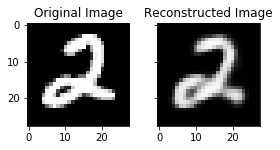

SSIM 0.85


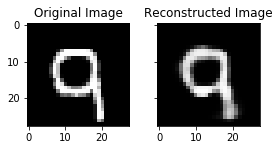

SSIM 0.92


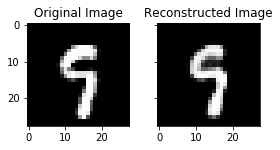

SSIM 0.84


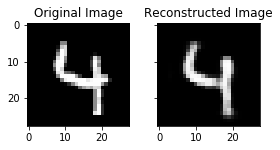

SSIM 0.84


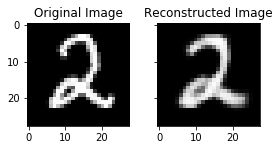

SSIM 0.87


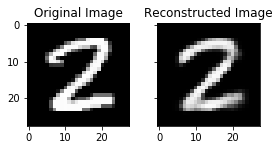

SSIM 0.89


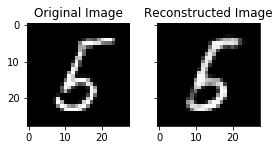

SSIM 0.91


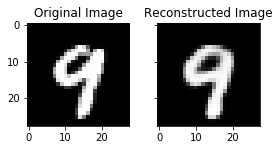

SSIM 0.79


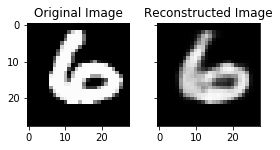

SSIM 0.79


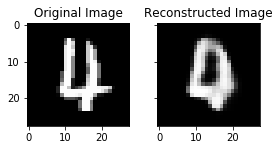

SSIM 0.93


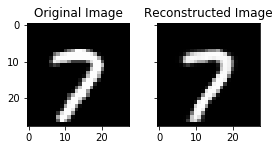

SSIM 0.9


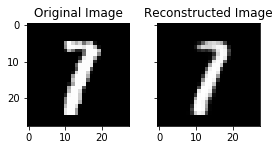

SSIM 0.85


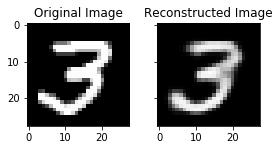

SSIM 0.87


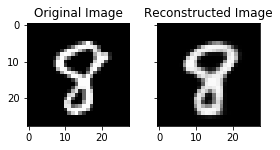

SSIM 0.88


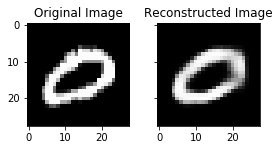

SSIM 0.89


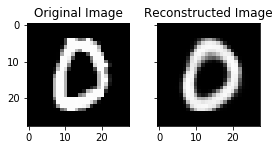

SSIM 0.88


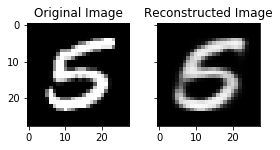

SSIM 0.9


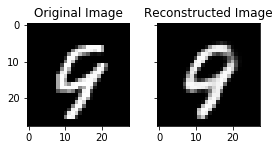

SSIM 0.92


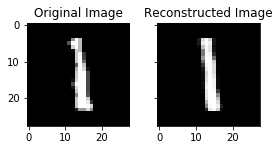

SSIM 0.82


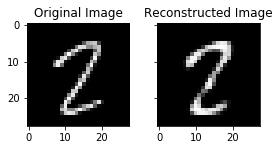

In [13]:
from skimage.measure import compare_ssim as ssim
sampl = 20
for z in range(sampl):
    indice = z
    img = x_test[indice,:].reshape((28,28))
    img = img#*255

    new,_ = rec(x_test[indice,:], weights, a, b, kstp=1)
    new = new.reshape((28,28))
    new = new#*255

    rows, cols = img.shape

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 4),
                             sharex=True, sharey=True)
    #ax = axes.ravel()

    #ssim_none = ssim(img, img, data_range=img.max() - img.min())
    ssim_rec = np.round(ssim(img, new, data_range=img.max() - img.min()),2)
    print("SSIM", ssim_rec)
    label = 'SSIM: {:.2f}'

    ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax[1].imshow(new, cmap=plt.cm.gray, vmin=0, vmax=1)
    #ax.set_xlabel(label.format(mse_noise, ssim_noise))
    ax[0].set_title('Original Image')
    ax[1].set_title('Reconstructed Image')

    plt.tight_layout()
    plt.show()